In [8]:
import requests, json
import pandas as pd
import numpy as np
import os
import glob
import gzip 
import torch
from transformers import BertForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import nltk
import ssl
from transformers import pipeline
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import matplotlib.pyplot as plt
from pandas_datareader import data
import yfinance as yf
import datetime
from transformers import pipeline
from IPython.display import clear_output
from statsmodels.api import OLS
import statsmodels.api as sm

# Loading the 'COVID headlines' 

In [9]:
df = pd.read_csv('/Users/marnixtimmermans/Desktop/Thesis1/Data/Sentiment Analysis/Headline_Japan.csv')

In [10]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date') 
df.Date = df.Date.dt.date
df

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname JST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


,Month,Date,Headline,Headline_Clean
6427,January,2020-01-09,China pneumonia outbreak may be linked to new ...,china pneumonia outbreak may link new virus
6192,January,2020-01-13,China virus outbreak linked to seafood market ...,china virus outbreak link seafood market not c...
6193,January,2020-01-14,Thailand reports case of coronavirus from China,thailand report case coronavirus china
6194,January,2020-01-14,Thailand reports case of coronavirus from China,thailand report case coronavirus china
6089,January,2020-01-15,Man infected with mysterious virus in China di...,man infect mysterious virus china die outbreak
...,...,...,...,...
4635,December,2020-12-01,China gave COVID-19 vaccine candidate to North...,china give vaccine candidate north korea kim a...
4636,December,2020-12-01,"Princess Aiko turns 19, hoping for a return to...",princess aiko turn hop return campus life
4637,December,2020-12-01,New Zealand joins Australia in denouncing Chin...,new zealand join australia denounce china tweet
4638,December,2020-12-01,Olympic rings return to Tokyo Bay,olympic ring return tokyo bay


# Cleaning, POS tagging and Lemmatizing

In [11]:
#Clean Text
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^ A-Za-z]+', ' ', text)
    return text

# Cleaning the text in the review column
df['cleaned_text'] = df['Headline'].apply(clean)
df.head()

,Month,Date,Headline,Headline_Clean,cleaned_text
6427,January,2020-01-09,China pneumonia outbreak may be linked to new ...,china pneumonia outbreak may link new virus,China pneumonia outbreak may be linked to new ...
6192,January,2020-01-13,China virus outbreak linked to seafood market ...,china virus outbreak link seafood market not c...,China virus outbreak linked to seafood market ...
6193,January,2020-01-14,Thailand reports case of coronavirus from China,thailand report case coronavirus china,Thailand reports case of coronavirus from China
6194,January,2020-01-14,Thailand reports case of coronavirus from China,thailand report case coronavirus china,Thailand reports case of coronavirus from China
6089,January,2020-01-15,Man infected with mysterious virus in China di...,man infect mysterious virus china die outbreak,Man infected with mysterious virus in China di...


In [12]:
# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

df['POS tagged'] = df['cleaned_text'].apply(token_stop_pos)
df.head()

,Month,Date,Headline,Headline_Clean,cleaned_text,POS tagged
6427,January,2020-01-09,China pneumonia outbreak may be linked to new ...,china pneumonia outbreak may link new virus,China pneumonia outbreak may be linked to new ...,"[(China, n), (pneumonia, n), (outbreak, n), (m..."
6192,January,2020-01-13,China virus outbreak linked to seafood market ...,china virus outbreak link seafood market not c...,China virus outbreak linked to seafood market ...,"[(China, n), (virus, n), (outbreak, n), (linke..."
6193,January,2020-01-14,Thailand reports case of coronavirus from China,thailand report case coronavirus china,Thailand reports case of coronavirus from China,"[(Thailand, n), (reports, n), (case, n), (coro..."
6194,January,2020-01-14,Thailand reports case of coronavirus from China,thailand report case coronavirus china,Thailand reports case of coronavirus from China,"[(Thailand, n), (reports, n), (case, n), (coro..."
6089,January,2020-01-15,Man infected with mysterious virus in China di...,man infect mysterious virus china die outbreak,Man infected with mysterious virus in China di...,"[(Man, n), (infected, v), (mysterious, a), (vi..."


In [13]:
#Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos = pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

df['text'] = df['POS tagged'].apply(lemmatize)
df.head()

,Month,Date,Headline,Headline_Clean,cleaned_text,POS tagged,text
6427,January,2020-01-09,China pneumonia outbreak may be linked to new ...,china pneumonia outbreak may link new virus,China pneumonia outbreak may be linked to new ...,"[(China, n), (pneumonia, n), (outbreak, n), (m...",China pneumonia outbreak may link new virus
6192,January,2020-01-13,China virus outbreak linked to seafood market ...,china virus outbreak link seafood market not c...,China virus outbreak linked to seafood market ...,"[(China, n), (virus, n), (outbreak, n), (linke...",China virus outbreak link seafood market cur...
6193,January,2020-01-14,Thailand reports case of coronavirus from China,thailand report case coronavirus china,Thailand reports case of coronavirus from China,"[(Thailand, n), (reports, n), (case, n), (coro...",Thailand report case coronavirus China
6194,January,2020-01-14,Thailand reports case of coronavirus from China,thailand report case coronavirus china,Thailand reports case of coronavirus from China,"[(Thailand, n), (reports, n), (case, n), (coro...",Thailand report case coronavirus China
6089,January,2020-01-15,Man infected with mysterious virus in China di...,man infect mysterious virus china die outbreak,Man infected with mysterious virus in China di...,"[(Man, n), (infected, v), (mysterious, a), (vi...",Man infect mysterious virus China dy outbreak


# Assigning DistilBERT scores

In [14]:
from transformers import pipeline

sentiment_analysis = pipeline("sentiment-analysis", return_all_scores=True)

results = []

for i in range(len(df)):
    clear_output(wait=True)
    result = sentiment_analysis(df['text'].iloc[i])[0]
    res_neg_score = sentiment_analysis(df['text'].iloc[i])[0][0]['score']
    res_pos_score = sentiment_analysis(df['text'].iloc[i])[0][1]['score']
    if res_neg_score > res_pos_score:
        results.append(0-res_neg_score)
        print(res_neg_score)
    else:
        results.append(res_pos_score)
        print(res_pos_score)
    
    print("Current progress:", np.round(i/len(df) * 100 , 2 ),"%")


print(result)
df['results'] = results

0.9466162919998169
Current progress: 100.0 %
[{'label': 'NEGATIVE', 'score': 0.9466162919998169}, {'label': 'POSITIVE', 'score': 0.053383730351924896}]


array([[<AxesSubplot:title={'center':'results'}>]], dtype=object)

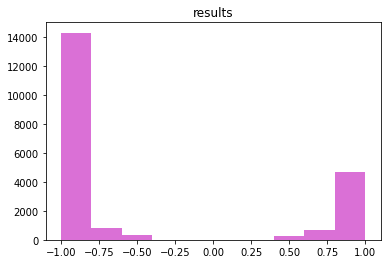

In [15]:
df.hist(column='results', grid=False, color='orchid')

# Check if all dates are in DF add remaining dates to DF



In [16]:
print(pd.date_range(start = '2020-03-01', end = '2020-09-30' ).difference(df.Date))
missing_dates = pd.date_range(start = '2020-03-01', end = '2020-09-30' ).difference(df.Date)
missing_dates_list = {'Date': missing_dates}

df = df.append(pd.DataFrame(missing_dates_list))

print(pd.date_range(start = '2020-03-01', end = '2020-09-30' ).difference(df.Date))


DatetimeIndex([], dtype='datetime64[ns]', freq=None)
DatetimeIndex([], dtype='datetime64[ns]', freq=None)


# Create DataFrame with average sentiment, frequency and mean per day and add day of the week variable



In [17]:

df_date_sentiment = df[['Date', 'results']]
df_date_sentiment.columns
print(df_date_sentiment.head())
variance = df_date_sentiment.groupby('Date', as_index=False)['results'].var()
print(variance)
count = df_date_sentiment.groupby('Date', as_index=False)['results'].count()
print(count)
df_date_sentiment = df_date_sentiment.groupby('Date', as_index=False)['results'].mean()
# mean = df_date_sentiment.groupby('Date', as_index=False)['results'].mean() 


merged_df = pd.merge(df_date_sentiment, variance, on="Date")
df_date_sentiment = pd.merge(merged_df, count, on="Date")
df_date_sentiment = df_date_sentiment.rename(columns={"results_x": "mean", "results_y": "variance", "results": "frequency"})

df_date_sentiment['Date'] = pd.to_datetime(df_date_sentiment['Date'])


df_date_sentiment['Day of week'] = df_date_sentiment.Date.dt.dayofweek
df_date_sentiment.head(30)

            Date   results
6427  2020-01-09 -0.958135
6192  2020-01-13 -0.928918
6193  2020-01-14 -0.941279
6194  2020-01-14 -0.941279
6089  2020-01-15 -0.963968
           Date   results
0    2020-01-09       NaN
1    2020-01-13       NaN
2    2020-01-14  0.000000
3    2020-01-15  0.000403
4    2020-01-16  1.687988
..          ...       ...
320  2020-11-27  0.737932
321  2020-11-28  0.822774
322  2020-11-29  0.647622
323  2020-11-30  0.741114
324  2020-12-01  0.688452

[325 rows x 2 columns]
           Date  results
0    2020-01-09        1
1    2020-01-13        1
2    2020-01-14        2
3    2020-01-15        2
4    2020-01-16        2
..          ...      ...
320  2020-11-27       68
321  2020-11-28       44
322  2020-11-29       37
323  2020-11-30       56
324  2020-12-01       39

[325 rows x 2 columns]


,Date,mean,variance,frequency,Day of week
0,2020-01-09,-0.958135,NaN,1,3
1,2020-01-13,-0.928918,NaN,1,0
2,2020-01-14,-0.941279,0.000000,2,1
3,2020-01-15,-0.978166,0.000403,2,2
4,2020-01-16,-0.031382,1.687988,2,3
5,2020-01-17,-0.490063,0.983829,4,4
6,2020-01-18,-0.986785,0.000178,3,5
7,2020-01-19,-0.919712,0.000322,3,6
8,2020-01-20,-0.055238,1.010941,6,0
9,2020-01-21,-0.750964,0.235889,9,1


# Average the sentiment of Saturdays and Sundays

In [18]:
for i , row in df_date_sentiment.iterrows():
    if df_date_sentiment['Day of week'][i] == 5 and df_date_sentiment['Day of week'][i + 1] == 6:
        df_date_sentiment['frequency'][i+1] = (df_date_sentiment['frequency'][i] + df_date_sentiment['frequency'][i+1]) / 2
        df_date_sentiment['mean'][i+1] = (df_date_sentiment['mean'][i] + df_date_sentiment['mean'][i+1]) / 2
        df_date_sentiment['variance'][i+1] = (df_date_sentiment['variance'][i] + df_date_sentiment['variance'][i+1]) / 2
        print('YES!')
df_date_sentiment

YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!


<ipython-input-18-ed66be361ce4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_date_sentiment['frequency'][i+1] = (df_date_sentiment['frequency'][i] + df_date_sentiment['frequency'][i+1]) / 2
<ipython-input-18-ed66be361ce4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_date_sentiment['mean'][i+1] = (df_date_sentiment['mean'][i] + df_date_sentiment['mean'][i+1]) / 2
<ipython-input-18-ed66be361ce4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

,Date,mean,variance,frequency,Day of week
0,2020-01-09,-0.958135,NaN,1,3
1,2020-01-13,-0.928918,NaN,1,0
2,2020-01-14,-0.941279,0.000000,2,1
3,2020-01-15,-0.978166,0.000403,2,2
4,2020-01-16,-0.031382,1.687988,2,3
...,...,...,...,...,...
320,2020-11-27,-0.394819,0.737932,68,4
321,2020-11-28,-0.354591,0.822774,44,5
322,2020-11-29,-0.418226,0.735198,40,6
323,2020-11-30,-0.404606,0.741114,56,0


# Exclude saturdays and make index of date

In [19]:
#Exclude Saturdays and make index of date
df_date_sentiment = df_date_sentiment.loc[df_date_sentiment['Day of week'] != 5]
df_date_sentiment = df_date_sentiment.set_index('Date')
print(len(df))
print(df.head(30))

21038
        Month        Date                                           Headline  \
6427  January  2020-01-09  China pneumonia outbreak may be linked to new ...   
6192  January  2020-01-13  China virus outbreak linked to seafood market ...   
6193  January  2020-01-14   Thailand reports case of coronavirus from China    
6194  January  2020-01-14    Thailand reports case of coronavirus from China   
6089  January  2020-01-15  Man infected with mysterious virus in China di...   
6090  January  2020-01-15  WHO says new China coronavirus could spread, w...   
6091  January  2020-01-16  Japan confirms first case of coronavirus that ...   
6195  January  2020-01-16  1st coronavirus case confirmed in Japan in man...   
6092  January  2020-01-17  Second person dies from SARS-linked coronaviru...   
6196  January  2020-01-17  World's biggest yearly human migration begins ...   
6197  January  2020-01-17  China says 2nd person dies in Wuhan pneumonia ...   
6198  January  2020-01-17  Thailan

# Import stock market index

In [20]:
import yfinance as yf

msft = yf.Ticker("^N225")

# get stock info
print(msft.info)

# get historical market data
hist = msft.history(start='2020-02-17', end='2020-12-01')

{'exchange': 'OSA', 'shortName': 'Nikkei 225', 'exchangeTimezoneName': 'Asia/Tokyo', 'exchangeTimezoneShortName': 'JST', 'isEsgPopulated': False, 'gmtOffSetMilliseconds': '32400000', 'quoteType': 'INDEX', 'symbol': '^N225', 'messageBoardId': 'finmb_INDEXN225', 'market': 'jp_market', 'previousClose': 27937.81, 'regularMarketOpen': 28309.6, 'twoHundredDayAverage': 28850.123, 'trailingAnnualDividendYield': None, 'payoutRatio': None, 'volume24Hr': None, 'regularMarketDayHigh': 28533.74, 'navPrice': None, 'averageDailyVolume10Day': 63910000, 'totalAssets': None, 'regularMarketPreviousClose': 27937.81, 'fiftyDayAverage': 28888.512, 'trailingAnnualDividendRate': None, 'open': 28309.6, 'toCurrency': None, 'averageVolume10days': 63910000, 'expireDate': None, 'yield': None, 'algorithm': None, 'dividendRate': None, 'exDividendDate': None, 'beta': None, 'circulatingSupply': None, 'startDate': None, 'regularMarketDayLow': 28226.43, 'priceHint': 2, 'currency': 'JPY', 'regularMarketVolume': 0, 'lastM

In [21]:
# Transform dates to DateTime
hist.index = pd.to_datetime(hist.index, unit = 'd')
hist['Day of week'] = hist.index.dayofweek



# Add Sunday dates and add the opening price of Monday to the Sunday 



In [22]:

dfnew = pd.DataFrame()
for i in range(len(hist)):
    if hist['Day of week'][i] == 4:
#         date = hist.index + datetime.timedelta(days=2) 
        dfnew = dfnew.append({'Date': hist.index[i], 'Close': hist.Close[i], 'Volume': hist.Volume[i], 'DOW': hist['Day of week'][i]}, ignore_index = True) 
        
        dfnew = dfnew.append({'Date': hist.index[i] + datetime.timedelta(days=2), 'Close': hist.Open[i+1], 'Volume': hist.Volume[i+1], 'DOW': 6}, ignore_index=True)
        
    
    
    else:
        dfnew = dfnew.append({'Date': hist.index[i], 'Close': hist.Close[i], 'Volume':hist.Volume[i], 'DOW': hist['Day of week'][i]}, ignore_index = True) 
       
    
dfnew = dfnew.set_index('Date')
dfnew


,Close,DOW,Volume
Date,,,
2020-02-17,23523.240234,0.0,54000000.0
2020-02-18,23193.800781,1.0,59500000.0
2020-02-19,23400.699219,2.0,61600000.0
2020-02-20,23479.150391,3.0,63300000.0
2020-02-21,23386.740234,4.0,62100000.0
...,...,...,...
2020-11-25,26296.859375,2.0,92500000.0
2020-11-26,26537.310547,3.0,63500000.0
2020-11-27,26644.710938,4.0,86200000.0


# Create final DataFrame with variable Price Change

In [23]:
dfnew['Price Change'] = " "
for i in range(1, len(dfnew)-1):
    dfnew['Price Change'][i] = (dfnew['Close'][i]-dfnew['Close'][i-1]) / dfnew['Close'][i-1] * 100

dfnew = dfnew[1:-1]  
dfnew

<ipython-input-23-9269887c063d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfnew['Price Change'][i] = (dfnew['Close'][i]-dfnew['Close'][i-1]) / dfnew['Close'][i-1] * 100


,Close,DOW,Volume,Price Change
Date,,,,
2020-02-18,23193.800781,1.0,59500000.0,-1.400485
2020-02-19,23400.699219,2.0,61600000.0,0.892042
2020-02-20,23479.150391,3.0,63300000.0,0.335251
2020-02-21,23386.740234,4.0,62100000.0,-0.393584
2020-02-23,22949.369141,6.0,105800000.0,-1.870167
...,...,...,...,...
2020-11-24,26165.589844,1.0,81700000.0,1.019791
2020-11-25,26296.859375,2.0,92500000.0,0.501688
2020-11-26,26537.310547,3.0,63500000.0,0.914372


In [24]:
final_df = pd.concat([df_date_sentiment, dfnew], axis=1)
pd.set_option('display.max_rows', None)
final_df = final_df.dropna()
final_df

,mean,variance,frequency,Day of week,Close,DOW,Volume,Price Change
Date,,,,,,,,
2020-02-18,-0.726464,0.390471,53,1,23193.800781,1.0,59500000.0,-1.400485
2020-02-19,-0.700129,0.435155,57,2,23400.699219,2.0,61600000.0,0.892042
2020-02-20,-0.671013,0.462857,59,3,23479.150391,3.0,63300000.0,0.335251
2020-02-21,-0.600686,0.567340,68,4,23386.740234,4.0,62100000.0,-0.393584
2020-02-23,-0.602758,0.563078,38,6,22949.369141,6.0,105800000.0,-1.870167
2020-02-25,-0.742935,0.371614,65,1,22605.410156,1.0,105800000.0,-1.498773
2020-02-26,-0.780869,0.316881,84,2,22426.189453,2.0,99300000.0,-0.792822
2020-02-27,-0.648825,0.512798,91,3,21948.230469,3.0,106200000.0,-2.131254
2020-02-28,-0.669727,0.494930,96,4,21142.960938,4.0,148500000.0,-3.66895


In [25]:
# Import those libraries
import pandas as pd
from scipy.stats import pearsonr

# Convert dataframe into series
list1 = final_df['mean']
list2 = final_df['Price Change']

#positive / negative news dataframe
# pos_news = list1.loc[list1['results'] > 0]
# neg_news = list1.loc[list1['results'] < 0]
# near_zero = df.loc[df['Budget'] > 0, 'Budget']

# Apply the pearsonr()
corr, _ = pearsonr(list1, list2)
print('Pearsons correlation: %.3f' % corr)



Pearsons correlation: 0.247


# OLS regression, no delay

In [26]:
Y = final_df['Price Change'].values.reshape(-1,1)
X = final_df['mean']
X = sm.add_constant(X)
model = sm.OLS(Y.astype(float),X.astype(float)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     14.69
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           0.000164
Time:                        12:24:45   Log-Likelihood:                -421.09
No. Observations:                 229   AIC:                             846.2
Df Residuals:                     227   BIC:                             853.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0369      0.272      3.815      0.0

In [ ]:
len(final_df)

In [34]:
final_df['7day_rolling_avg'] = final_df['mean'].rolling(7).mean()

In [ ]:
# plot_price_change = final_df.plot(use_index=True, y=['Close'], color='orchid')
# plot_sentiment = final_df.plot(use_index=True, y=['mean'], color='orchid')
plot_rolling_avg_sentiment = final_df.plot(use_index=True, y=['7day_rolling_avg'], color='orchid')
# ax.set_ylim(-5,5)
plt.xlabel('Date')
plt.ylabel('Rolling Average Sentiment')
plt.show()

# ADF Statistic

In [25]:
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
series = final_df
X = final_df['mean']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.053405
p-value: 0.263659
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574


# Granger Causality

In [26]:
final_df['mean_dif'] = final_df['mean']-final_df['mean'].shift(1)

In [29]:
var_df = final_df[['Price Change', 'mean_dif']]

In [30]:
var_df = var_df[1:]

In [52]:
len(var_df)

229

In [31]:
var_df['Price Change'] = var_df['Price Change'].astype(float)
var_df['mean_dif'] = var_df['mean_dif'].astype(float)

In [32]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [33]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(var_df[['Price Change', 'mean_dif']], maxlag=10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6915  , p=0.0560  , df_denom=224, df_num=1
ssr based chi2 test:   chi2=3.7410  , p=0.0531  , df=1
likelihood ratio test: chi2=3.7105  , p=0.0541  , df=1
parameter F test:         F=3.6915  , p=0.0560  , df_denom=224, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0376  , p=0.0500  , df_denom=221, df_num=2
ssr based chi2 test:   chi2=6.2126  , p=0.0448  , df=2
likelihood ratio test: chi2=6.1288  , p=0.0467  , df=2
parameter F test:         F=3.0376  , p=0.0500  , df_denom=221, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0698  , p=0.1052  , df_denom=218, df_num=3
ssr based chi2 test:   chi2=6.4088  , p=0.0933  , df=3
likelihood ratio test: chi2=6.3192  , p=0.0971  , df=3
parameter F test:         F=2.0698  , p=0.1052  , df_denom=218, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7785  , p=0.1342  

{1: ({'ssr_ftest': (3.691529291981081, 0.05595861896487952, 224.0, 1),
   'ssr_chi2test': (3.7409694164272564, 0.05309363314605454, 1),
   'lrtest': (3.71047829145175, 0.05407189450623993, 1),
   'params_ftest': (3.6915292919810985, 0.05595861896487826, 224.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.037598866301336, 0.049956761586338654, 221.0, 2),
   'ssr_chi2test': (6.212645645104995, 0.04476526287622953, 2),
   'lrtest': (6.128787475165836, 0.04668213491104535, 2),
   'params_ftest': (3.0375988663013467, 0.04995676158633753, 221.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.0697993280173463, 0.10515054469748858, 218.0, 3),
   'ssr_chi2test': (6.40878232298949, 0.09333015965641207, 3),
   'lrtest': (6.319207086688948, 0.09707180858295456, 3),
   'params_ftest': (2.069799328017353, 0.10515054469748827, 218.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0